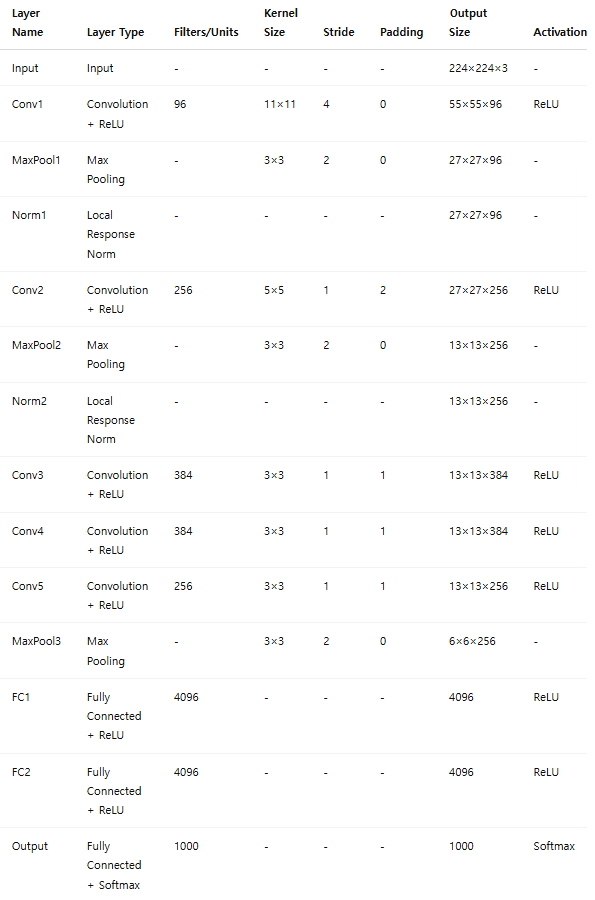

Input Layer - Conv1 - MaxPool1 - Norm1 - Conv2 - MaxPool2 - Norm2 - Conv3 - Conv4 - Conv5 - MaxPool3 - FC1 - FC2 - Output Layer




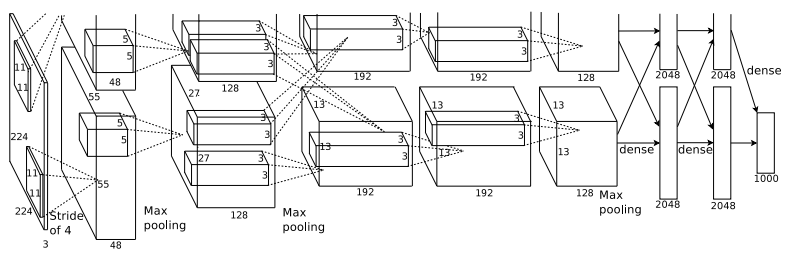

In [29]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

In [30]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [31]:
resize_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [32]:
from torch.utils.data import Subset
temp_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=resize_transform)
subset = Subset(temp_train_set, range(1000))
mean_image = torch.stack([img for img, _ in subset]).mean(dim=0)  # (C, 224, 224)

In [33]:
class SubtractMeanImage:
    def __init__(self, mean_img):
        self.mean_img = mean_img
    def __call__(self, img):
        return img - self.mean_img

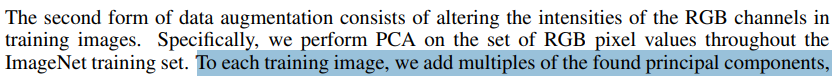

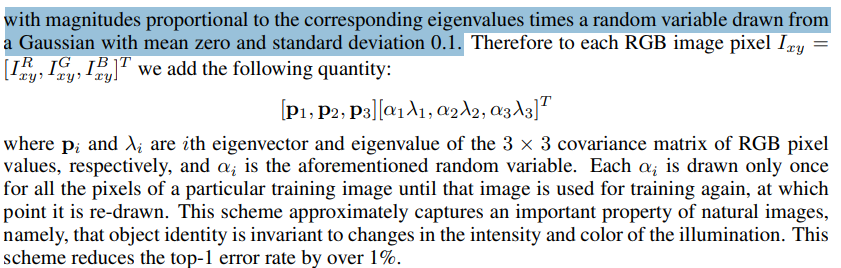

In [34]:
from PIL import Image

class Lighting(object):
    """
    AlexNet-style PCA-based color augmentation
    """
    def __init__(self, alphastd, eigval=None, eigvec=None):
        self.alphastd = alphastd
        self.eigval = eigval if eigval is not None else np.array([0.2175, 0.0188, 0.0045])
        self.eigvec = eigvec if eigvec is not None else np.array([
            [-0.5675,  0.7192,  0.4009],
            [-0.5808, -0.0045, -0.8140],
            [-0.5836, -0.6948,  0.4203],
        ])

    def __call__(self, img):
        if self.alphastd == 0:
            return img
        alpha = np.random.normal(0, self.alphastd, size=(3,))
        rgb = np.dot(self.eigvec.T * alpha, self.eigval)
        img = np.asarray(img).astype(np.float32)
        for i in range(3):
            img[..., i] += rgb[i]
        img = np.clip(img, 0, 255).astype(np.uint8)
        return Image.fromarray(img.astype('uint8'))

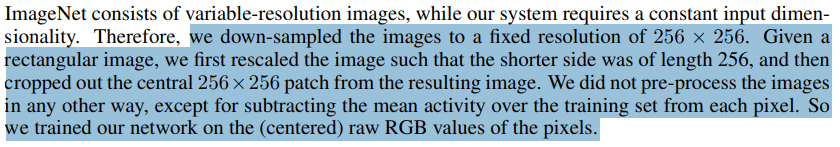

In [35]:
alexnet_train_transform = transforms.Compose([
    transforms.Resize(256),            # 짧은 변 256 맞추기
    transforms.CenterCrop(256),       # 중앙 crop → 임시로 256×256 확보
    transforms.RandomCrop(224),       # 무작위 224 crop
    transforms.RandomHorizontalFlip(),# 좌우 반전
    Lighting(0.1),
    transforms.ToTensor(),
    SubtractMeanImage(mean_image)
])

In [36]:
alexnet_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),       # 중앙 224 crop
    transforms.ToTensor(),
    SubtractMeanImage(mean_image)
])

In [37]:
train_set.transform = alexnet_train_transform
test_set.transform = alexnet_test_transform

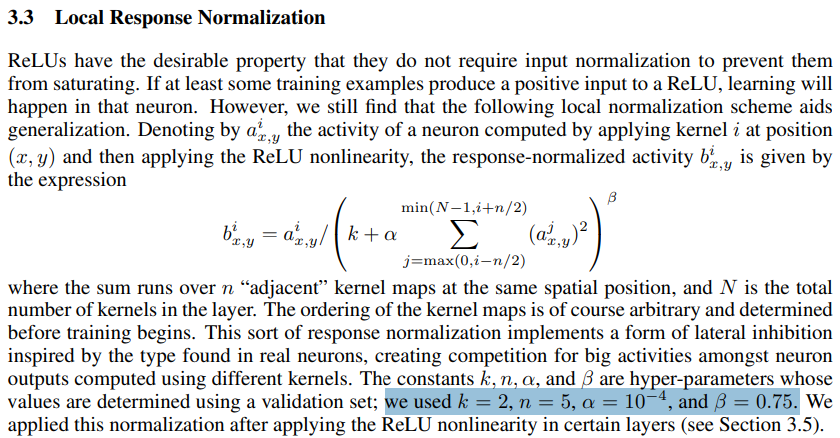

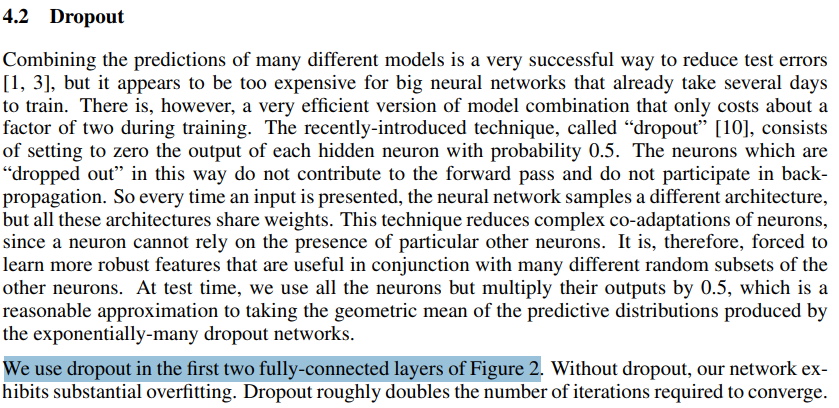

In [38]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
    )
    self.fc = nn.Sequential(
        nn.Linear(in_features=256*6*6, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),

        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),

        nn.Linear(in_features=4096, out_features=num_classes), # 1000-way softmax
    )
  def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [39]:
# train/val split (90/10)
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])
val_set.dataset.transform = alexnet_test_transform  # val은 augmentation 없이 test transform

In [40]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

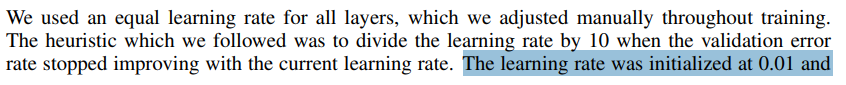

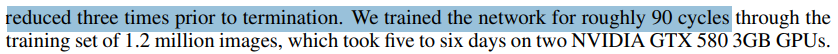

In [41]:
import torch.optim as optim

model = AlexNet(num_classes=10)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0005 # L2 regularization
)
criterion = nn.CrossEntropyLoss() # LogSoftmax + NLLLoss

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(20): # 원래는 90
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_acc_list.append(val_acc)
    print(f"[Epoch {epoch+1}] Validation Acc: {val_acc:.2f}%")

[Epoch 1] Train Loss: 2.3027 | Train Acc: 10.05%
[Epoch 1] Validation Acc: 9.68%
[Epoch 2] Train Loss: 2.3023 | Train Acc: 10.45%
[Epoch 2] Validation Acc: 10.02%
[Epoch 3] Train Loss: 2.1655 | Train Acc: 19.23%
[Epoch 3] Validation Acc: 28.20%
[Epoch 4] Train Loss: 1.7301 | Train Acc: 35.14%
[Epoch 4] Validation Acc: 41.34%
[Epoch 5] Train Loss: 1.5129 | Train Acc: 43.96%
[Epoch 5] Validation Acc: 47.50%
[Epoch 6] Train Loss: 1.3632 | Train Acc: 50.11%
[Epoch 6] Validation Acc: 50.26%
[Epoch 7] Train Loss: 1.2370 | Train Acc: 55.07%
[Epoch 7] Validation Acc: 59.40%
[Epoch 8] Train Loss: 1.1006 | Train Acc: 60.59%
[Epoch 8] Validation Acc: 64.04%
[Epoch 9] Train Loss: 0.9870 | Train Acc: 64.99%
[Epoch 9] Validation Acc: 66.06%
[Epoch 10] Train Loss: 0.8931 | Train Acc: 68.66%
[Epoch 10] Validation Acc: 69.70%
[Epoch 11] Train Loss: 0.7922 | Train Acc: 72.19%
[Epoch 11] Validation Acc: 70.08%
[Epoch 12] Train Loss: 0.7165 | Train Acc: 74.93%
[Epoch 12] Validation Acc: 73.54%
[Epoch 13] 

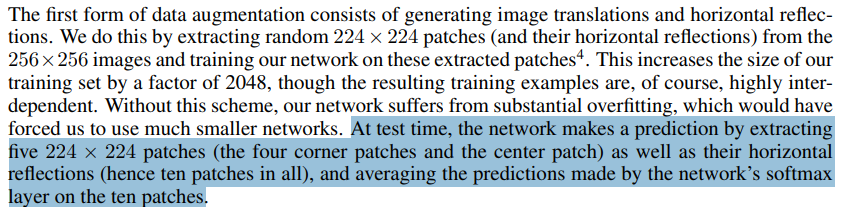

In [47]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # (B, num_classes)
        preds = outputs.argmax(dim=1)  # (B,)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100. * correct / total:.2f}%")

Test Accuracy: 79.18%


In [45]:
from torchvision.transforms import functional as TF
import torch.nn.functional as F

def ten_crop(image):
    crops = TF.ten_crop(image, size=224)  # 5 crops + 5 flips
    crops = [TF.to_tensor(crop) for crop in crops]  # Tensor 변환
    return torch.stack(crops)  # (10, C, H, W)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        all_preds = []
        for i in range(images.size(0)):
            image = transforms.ToPILImage()(images[i].cpu())  # Tensor → PIL
            crops = ten_crop(image).to(device)  # (10, C, H, W)

            outputs = model(crops)             # (10, num_classes)
            probs = F.softmax(outputs, dim=1)  # (10, num_classes)
            mean_prob = probs.mean(dim=0)      # (num_classes)

            pred = mean_prob.argmax().item()
            all_preds.append(pred)

        preds = torch.tensor(all_preds).to(device)
        labels = labels.to(device)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

print(f"10-Crop Test Accuracy: {100. * correct / total:.2f}%")

10-Crop Test Accuracy: 25.56%
